# Analysis of the Curation Exercise Conducted in INDRA

This notebook analyzes the results of the curation exercise conducted with [INDRA](https://github.com/sorgerlab/indra) [1] described in Hoyt *et al.*.
The notebook is divided in three sections:

1. Performance of BEL statement extraction 
2. Error encountered by INDRA
3. Curation effort with respect to manual curation

### References

1. Gyori, B. M., *et al.* (2017). From word models to executable models of signaling networks using automated assembly. Mol. Syst. Biol. 13.11: 954.
2. Hoyt, C. T., *et al.* (2019). Re-curation and Rational Enrichment of Knowledge Graphs in Biological Expression Language.
3. Szostak, J., *et al.* (2015). Construction of biological networks from unstructured information based on a semi-automated curation workflow. Database, 2015.

In [1]:
import os
import sys
import time
from collections import defaultdict
from statistics import mean
from operator import itemgetter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
%matplotlib inline

In [3]:
print(sys.version)

3.6.5 (default, Apr 20 2018, 08:54:42) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-16)]


In [4]:
print(time.asctime())

Wed Jan  2 15:24:54 2019


Load excel sheets

In [5]:
DATA_FOLDER = os.path.join(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', 'data')))

# Excel sheet with error count for each gene
errors_file_path = os.path.join(DATA_FOLDER, 'error_types.csv')

# Excel sheet with statistics about curation
curation_stats_path = os.path.join(DATA_FOLDER, 'curation_summary.csv')

# Excel sheet with curation time info
time_curation_path = os.path.join(DATA_FOLDER, 'curation_overview_table.xlsx')

#### Exclusion criteria
1. In one particular case, for GABRG1, there was only one statement extracted and this statement was wrong
2. For SLC5A7, INDRA made the same error consistently through the excel sheet and there was not any correct
3. MAPT and GSK3B were curated but they did not follow the rational curation procedure.

In [6]:
BLACKLIST = {'SLC5A7', 'GSK3B', 'MAPT', 'GABRG1'}

Load excel sheets with Pandas and replace NaN by zeros

In [7]:
errors_df = pd.read_csv(errors_file_path, index_col=0)
errors_df = errors_df[[v not in BLACKLIST for v in errors_df.index]]
errors_df.fillna(0, inplace=True)

curation_df = pd.read_csv(curation_stats_path, index_col=0)
curation_df.fillna(0, inplace=True)
curation_df = curation_df[
    [v not in BLACKLIST 
     for v in curation_df.index]
]

time_df = pd.read_excel(time_curation_path, index_col=0)
time_df = time_df[
    [v not in BLACKLIST
     for v in time_df.index]
]

# Ensures the genes in both excel completely match 
assert set(curation_df.index.values) == set(time_df.index.values) , "Genes in both excel should match"

The following genes were done in the first round of curation before we began annotating error types and are therefore excluded from the error analysis presented in Part 2 of this notebook.

In [8]:
print(*sorted(set(time_df.index.values) - set(errors_df.index.values)))

ARG1 CHI3L2 DEFB1 GABRG3 GABRP HDLBP HLA-DQB1 IGFL1 IL4R INA LAMP1 LAMTOR1 MAPK8IP1 MYH9 PTGER2 SLC1A2 SLC39A1 THBS3 TPM1 USF2


# Part 1: Performance of BEL Statement Extraction

Analyzing the accuracy of INDRA to extract correct BEL statements.

In [9]:
# Correct statements identified by INDRA for each gene (correct / total curated)
avg_corrected = {}

# Statements that could be extracted for each gene (correct + modified by curator)
avg_triplets_extracted = {}

# Min/statement for each curator
curator_time_dict = defaultdict(list)

# Statements checked for each gene
statements_checked = {}

# Gene to avg curation effort
gene_curation_effort = {}

for gene_symbol, (correct, error, other_statement, modified, not_curated, total) in curation_df.iterrows():
    total_curated = total - not_curated
    
    statements_checked[gene_symbol] = total_curated
    
    # Total statements recovered 
    statements_recovered = correct + modified + other_statement
        
    time_gene = time_df.loc[gene_symbol] # Get info for the given gene
    
    curator = time_gene['Curator']
    total_time = time_gene['Time (min)']
    
    # Calculate accuracy
    avg_corrected[gene_symbol] = correct / total_curated
    
    # Calculate the relative number of recovered (curated) statements from the total extracted by INDRA
    avg_triplets_extracted[gene_symbol] = statements_recovered / total_curated
    
    min_per_statement = total_time/statements_recovered
    
    # Time effort calculations (min/statement)
    curator_time_dict[curator].append(min_per_statement)
    
    gene_curation_effort[gene_symbol] = min_per_statement

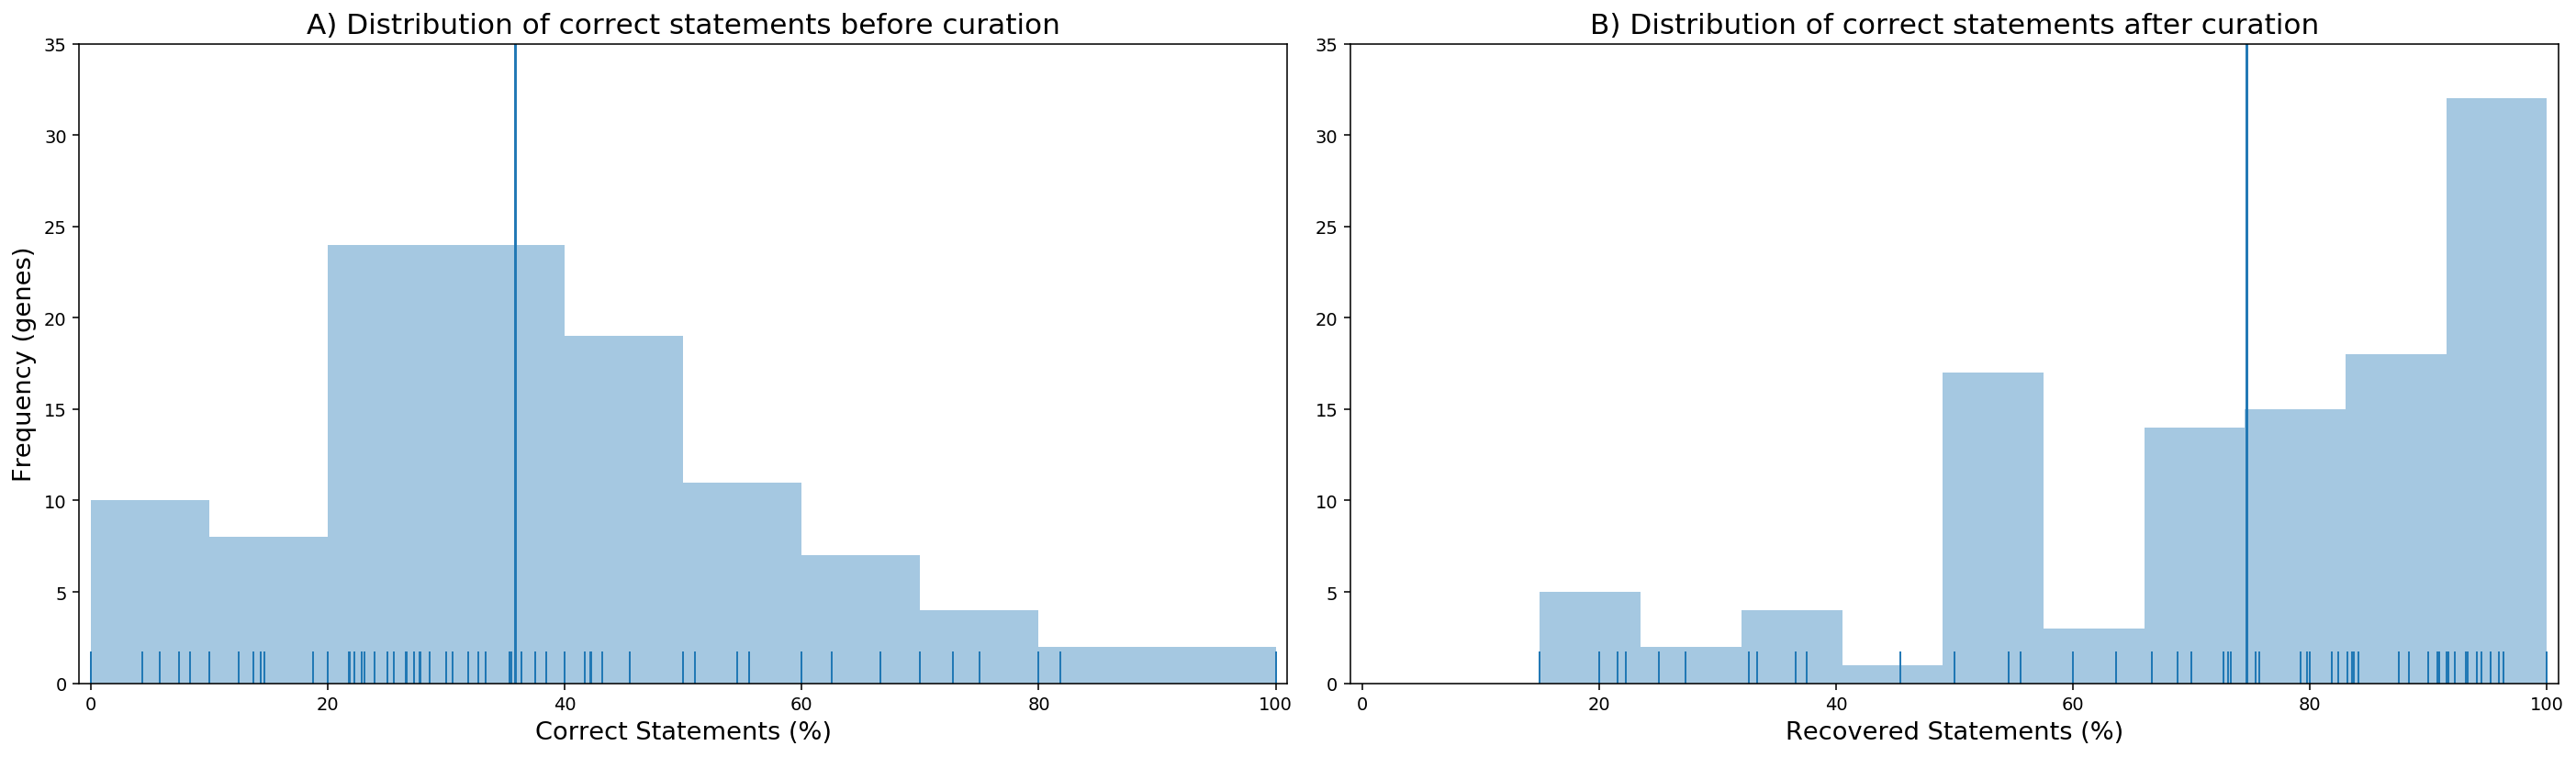

In [10]:
fig = plt.figure(figsize=(30, 6), dpi=140)

ax = fig.add_subplot(1, 3, 1)
ax.set_title('A) Distribution of correct statements before curation', fontsize=16)
ax.set_xlabel('Correct Statements (%)', fontsize=14)
ax.set_ylabel('Frequency (genes)', fontsize=14)
ax.set_xlim(-1, 101)
ax.set_ylim(0, 35)

sns.distplot(
    [
        value * 100 
        for value in avg_corrected.values() # Normalize accuracies to 100%
    ],
    kde=False,
    rug=True, 
    bins=10
)

mean_corrected = mean(avg_corrected.values()) * 100

# Plot average line
ax.axvline(x=mean_corrected)

ax = fig.add_subplot(1, 3, 2)
ax.set_title('B) Distribution of correct statements after curation', fontsize=16)
ax.set_xlabel('Recovered Statements (%)', fontsize=14)
ax.set_xlim(-1, 101)
ax.set_ylim(0, 35)

sns.distplot(
    [
        value * 100
        for value in avg_triplets_extracted.values() # Normalize statements extracted to 100%
    ], 
    kde=False,
    rug=True, 
    bins=10
)

mean_recovered = mean(avg_triplets_extracted.values()) * 100

# Plot average line
ax.axvline(x=mean_recovered)

plt.tight_layout()
plt.show()

__Figure 1a.__ Distribution of the INDRA statement accuracies. The above figure shows what is the percentage of correct statements directly coming from INDRA. While for some genes present a high accuracy, othe genes are hard to extract (*see Table 1 and 2*). The reason for that is that each gene presents distintive features (e.g., some gene symbols are similar to common acronyms, __TODO__).

__Figure 1b.__ Relative number of recovered BEL statements after curation. The distribution shows how the majority of the genes present a high recovery rate. In other words, most of statements extracted by INDRA were valid to capture the knowledge around the particular gene after curation).

In [11]:
print(f'Mean of the Accuracy: {mean_corrected:.2f}')
print(f'Mean of Recovered Statements: {mean_recovered:.2f}')

Mean of the Accuracy: 35.75
Mean of Recovered Statements: 74.63


In [12]:
top_10_genes_high_accuracy = [
    (gene_symbol, round(accuracy * 100, 2))
    for gene_symbol, accuracy in sorted(avg_corrected.items(), key=itemgetter(1), reverse=True)[:10]
]

pd.DataFrame(top_10_genes_high_accuracy, columns=["Gene Symbol", "Accuracy (%)"])

,Gene Symbol,Accuracy (%)
0,GABRG3,100.00
1,GABRP,100.00
2,IL23A,81.82
3,IGFL1,80.00
4,CHRM3,75.00
5,IRAK2,72.73
6,PLA2G4A,70.00
7,TNF,70.00
8,APBB2,66.67
9,LAMB2,66.67


**Table 1.** Genes with top 10 highest accuracies

In [13]:
top_10_genes_low_accuracy = [
    (gene_symbol, round(accuracy * 100, 2))
    for gene_symbol, accuracy in sorted(avg_corrected.items(), key=itemgetter(1))[:10]
]

pd.DataFrame(top_10_genes_low_accuracy, columns=["Gene Symbol", "Accuracy (%)"])

,Gene Symbol,Accuracy (%)
0,BLMH,0.00
1,CADPS2,0.00
2,NOD2,0.00
3,NRGN,0.00
4,THBS3,0.00
5,TIMP1,0.00
6,GABBR1,4.35
7,CD274,5.80
8,CTTN,7.41
9,MRC1,8.33


**Table 2.** Genes with bottom 10 lowest accuracies

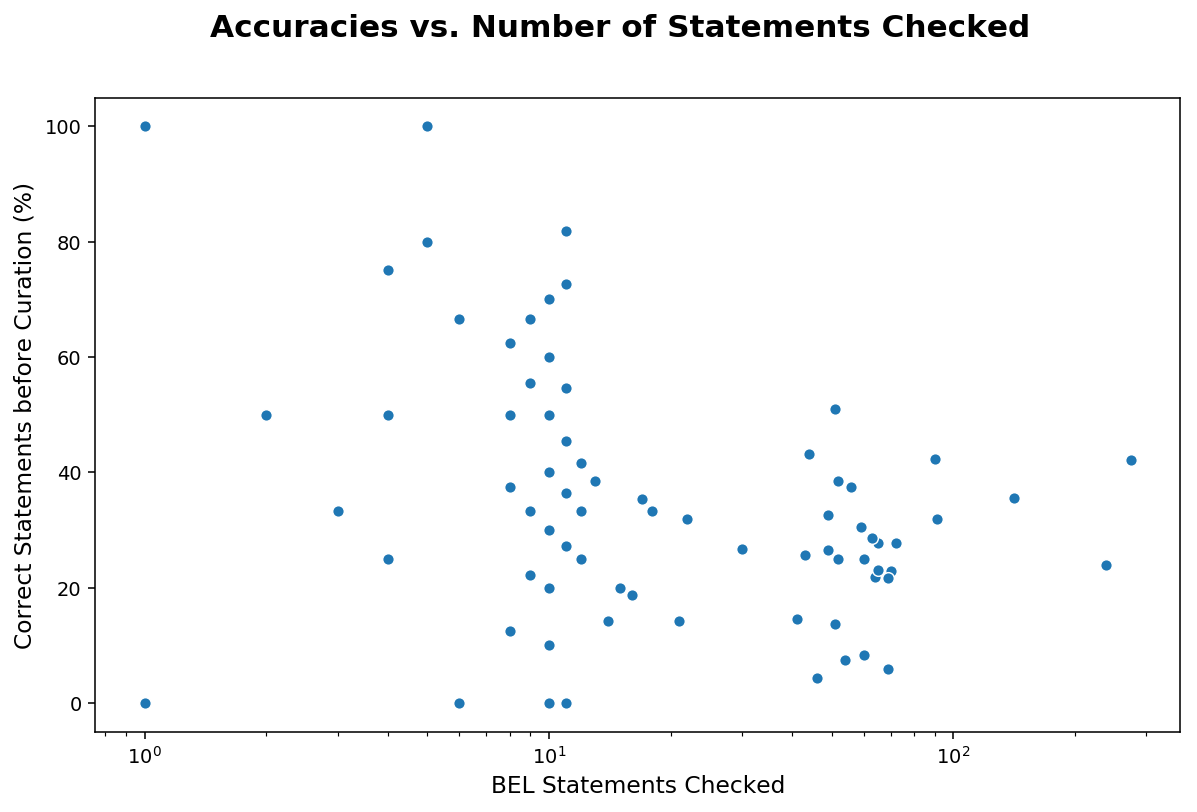

In [14]:
fig = plt.figure(figsize=(10, 6), dpi=140)

# Rearrange data for the plot
data_scatterplot = [
    (gene_symbol, accuracy * 100, statements_checked[gene_symbol])
    for gene_symbol, accuracy in avg_corrected.items()
]

df_scatterplot = pd.DataFrame(data_scatterplot, columns=('Gene Symbol', 'Accuracy', 'Statements Checked'))

sns.scatterplot(x="Statements Checked", y="Accuracy", data=df_scatterplot)

plt.gca().set(xscale="log")

fig.suptitle('Accuracies vs. Number of Statements Checked', fontsize=16,fontweight='bold')
plt.xlabel('BEL Statements Checked', fontsize=12)
plt.ylabel('Correct Statements before Curation (%)', fontsize=12)

plt.show()

__Figure 2__. BEL statements checked vs. correct BEL statements before curation (accuracy of INDRA readers). While most of the genes have an accuracy close to the mean (35.75%), there exist some outliers close to 0 and 100% (dots at the leftmost part of the figure). The figure shows that the reason for these outliers is that they only contained a limited amount of statements.

# Part 2: Errors Encountered by INDRA

Detailed information about each error type can be found at https://github.com/pharmacome/curation/blob/master/indra-errors.rst

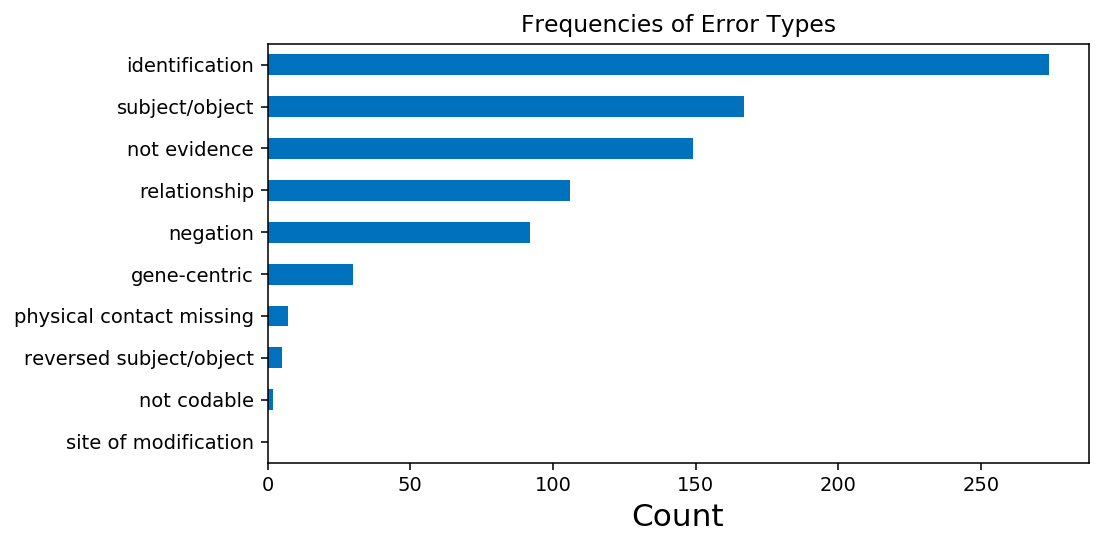

In [15]:
plt.figure(num=None, figsize=(8, 4), dpi=140, facecolor='w', edgecolor='k')

# Aggregate sum for each error type through the dataframe
error_sum = errors_df.sum()

ax = error_sum.sort_values().plot.barh(color=['#0072bd'])
ax.set_title('Frequencies of Error Types')
ax.set_xlabel("Count", fontsize=16)

plt.tight_layout()
plt.show()

__Figure 3__. The bar chart shows the most common errors annotated by the curators while checking the statements automatically extracted by INDRA. A more detailed explanation of each error can be found at https://github.com/pharmacome/curation/blob/master/indra-errors.rst.

# Part 3: Manual Curation Effort

In this part of the notebook, we analyze whether the proposed workflow with INDRA requires less amount of time to extract a valid BEL statement than standard manual curation.

In [16]:
"""Adapted from https://stackoverflow.com/questions/11517986/indicating-the-statistically-significant-difference-in-bar-graph"""
def barplot_annotate_brackets(num1, num2, data, center, height, dh=.05, barh=.05, fs=None, maxasterix=None):

    text = data

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y + barh, y + barh, y]
    mid = ((lx + rx) / 2, y + barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

_T-test statistics comparing both groups_

In [17]:
bottom_20_low_accuracy_genes = [
    gene_curation_effort[gene_symbol]
    for gene_symbol, _ in sorted(avg_corrected.items(), key=itemgetter(1))[:20]
]

top_20_high_accuracy_genes = [
    gene_curation_effort[gene_symbol]
    for gene_symbol, _ in sorted(avg_corrected.items(), key=itemgetter(1), reverse=True)[:20]
]

In [18]:
_, p_value = ttest_ind(top_20_high_accuracy_genes, bottom_20_low_accuracy_genes)
print(p_value)

0.003782842828606878


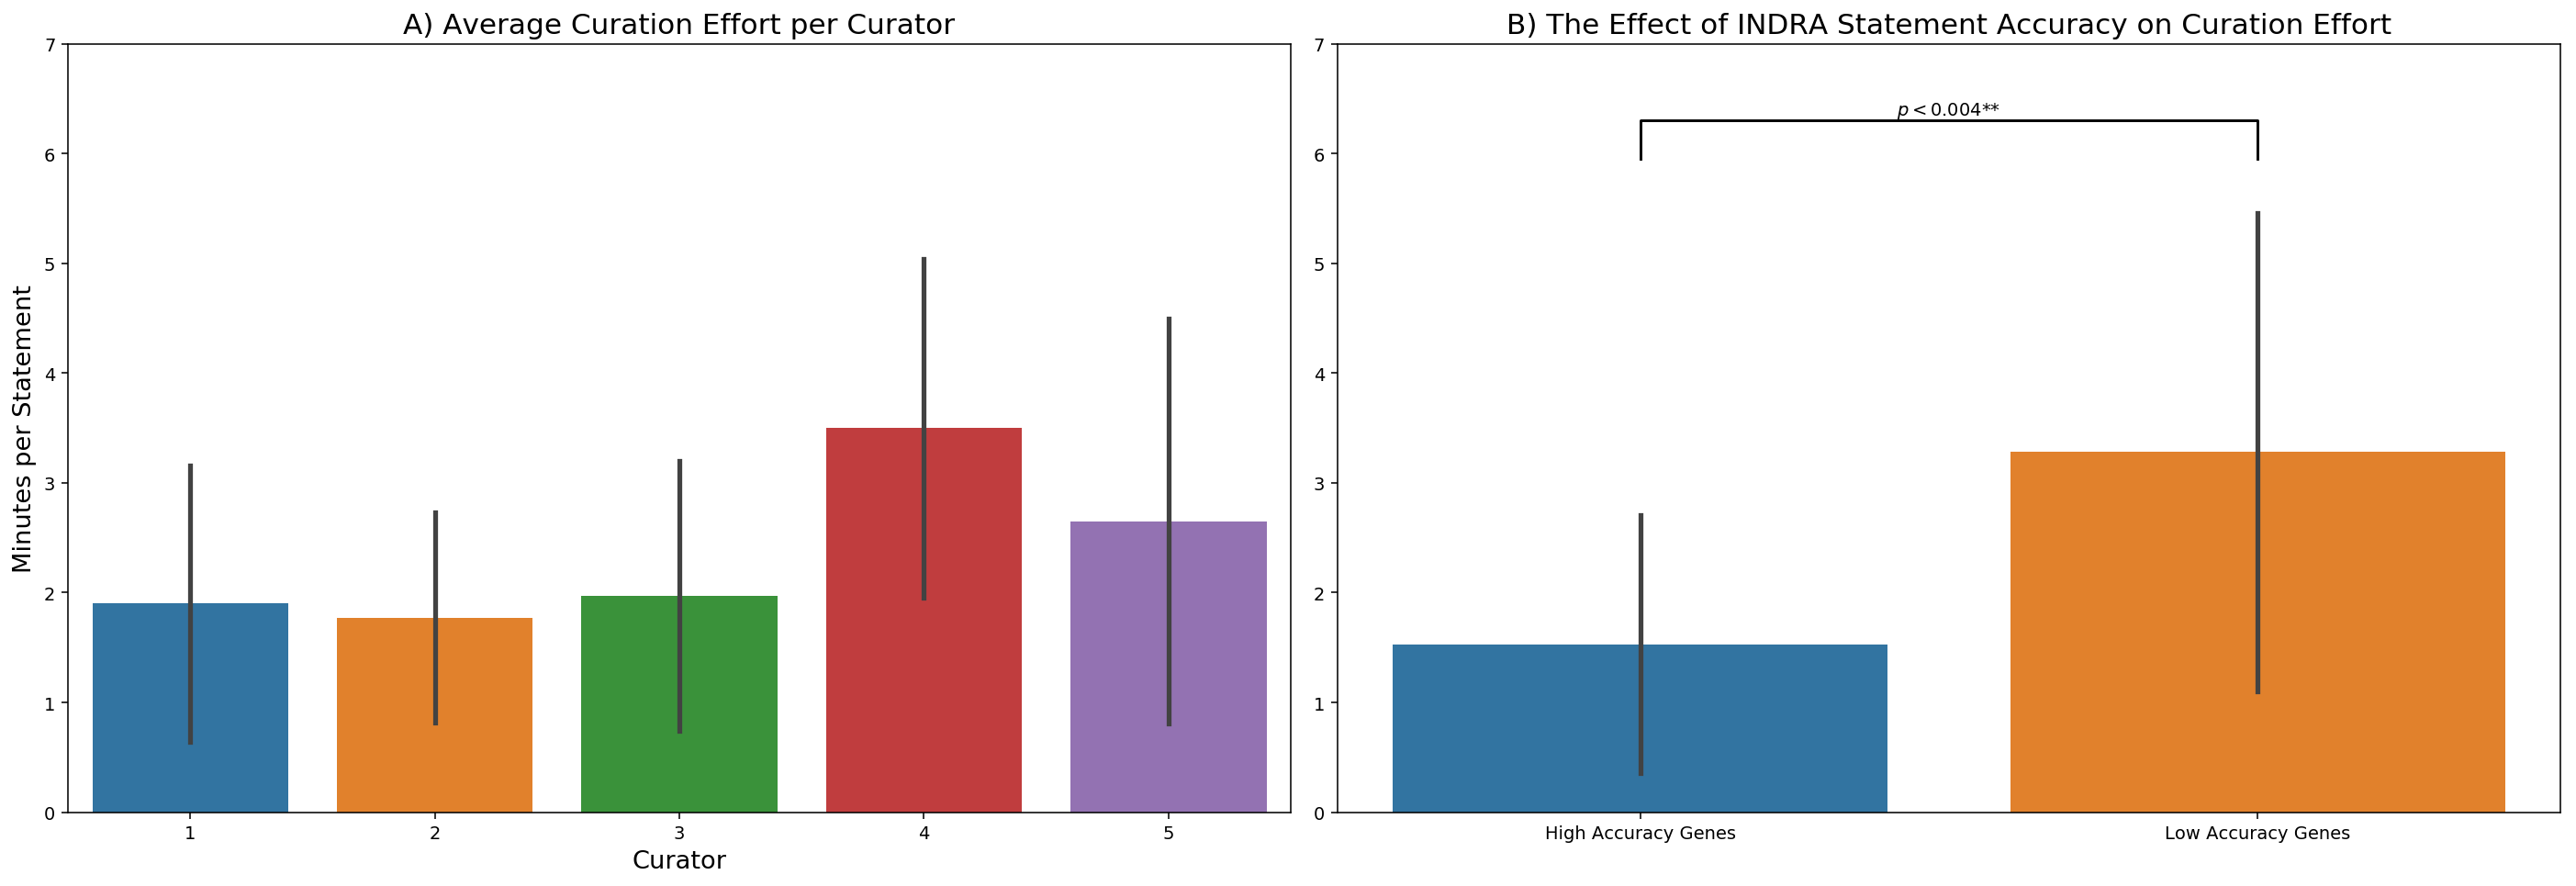

In [34]:
fig = plt.figure(figsize=(30, 7), dpi=140)

"""Figure a)"""
ax = fig.add_subplot(1, 3, 1)

# Rearrange data for the plot
data_df = pd.DataFrame({
    '1': pd.Series(curator_time_dict[1]),
    '2': pd.Series(curator_time_dict[2]),
    '3': pd.Series(curator_time_dict[3]),
    '4': pd.Series(curator_time_dict[4]),
    '5': pd.Series(curator_time_dict[5])
})

ax = sns.barplot(data=data_df, ci="sd")

ax.set_title('A) Average Curation Effort per Curator', fontsize='16')
ax.set_xlabel("Curator", fontsize=14)
ax.set_ylabel("Minutes per Statement", fontsize=14)
ax.set_ylim(0, 7)

"""Figure b)"""
ax = fig.add_subplot(1, 3, 2)
ax.set_title('B) The Effect of INDRA Statement Accuracy on Curation Effort', fontsize='16')

comparison_data = pd.DataFrame.from_dict({
    "High Accuracy Genes": top_20_high_accuracy_genes,
    "Low Accuracy Genes":  bottom_20_low_accuracy_genes, 
})

ax = sns.barplot(data = comparison_data,ci="sd")
ax.set_ylim(0, 7)

barplot_annotate_brackets(0, 1, '$p<{}$**'.format(round(p_value, 3)), [0, 1], [1.5, 5.6])

plt.tight_layout()
plt.show()

**Figure 4a**. Average curation effort per curator measured in minutes per statement (minutes required to curate one a valid BEL statement). Four out of the five curators outperformed the estimated time for manual curation (3.2 minutes per statement) [3]. The variability in the standard deviation is explained by the difficulty of INDRA to recognize certain genes as illustrated by part b of the figure. Since the majority of the statements for that gene are wrong and the curator needs to read the evidence, the time required to curate statements of that genes significantly increases with respect to other genes.

**Figure 4b**. Comparison of the curation effort between genes whose statements are accurately recognized by INDRA (top 20) and genes presenting low accuracies (top 20). While genes with high accuracy present a curation effort that halves the average time when conducting manual curation (1.53 minutes vs. 3.28 minutes), genes with low accuracy require a similar effort (3.28 minutes vs. 3.2 minutes). Indeed, the difference between the two groups (genes with low/high accuracies) present a significant difference of $p<0.04)$.